# NLP Disaster Tweets Classification - Kaggle Mini-Project

**Author:** Fatih Uenal

**Course:** CU Boulder MSc Computer Science & AI

**Date:** 10.06.2025

**GitHub Repository:** [Github](https://github.com/FUenal/week4_nlp_mini_project_msc_compsci_final)

-----

## 1\. Brief Description of the Problem and Data

This project tackles a real-world Natural Language Processing (NLP) challenge: to build a model that can automatically classify tweets as being about a real disaster (`target=1`) or not (`target=0`). This is a binary text classification problem, directly inspired by the [Kaggle NLP with Disaster Tweets competition](https://www.kaggle.com/competitions/nlp-getting-started).

  * **Natural Language Processing (NLP):** This field of AI focuses on enabling computers to understand, interpret, and generate human language. In this project, we use NLP to analyze the text of tweets and predict their category. The challenge lies in the ambiguity and informal nature of Twitter data, which often includes slang, abbreviations, and metaphorical language.

  * **The Data:** The dataset is provided in three files: `train.csv`, `test.csv`, and `sample_submission.csv`.

      * `train.csv`: Contains the training data with the following columns: `id`, `keyword`, `location`, `text`, and `target`.
      * `test.csv`: Contains the test data for which we need to predict the `target`. It has the same columns as the training data, except for the `target` column.

    <!-- end list -->

      - `sample_submission.csv`: Shows the required format for the submission file.

The primary feature for our model will be the `text` of the tweets. The `keyword` and `location` columns have missing values but may provide useful context.

-----

## 2\. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Data Inspection

First, I'll load the data and inspect its structure, including the shape and the presence of missing values.

| Dataset | \# Rows | \# Columns | Labeled? |
| :--- | :--- | :--- | :--- |
| train.csv | \~7,613 | 5 | Yes |
| test.csv | \~3,263 | 4 | No |

The training data has 7,613 tweets, and the test set has 3,263. A significant number of `keyword` and `location` entries are missing, which will need to be addressed during data cleaning.

### Class Distribution and Tweet Length

The dataset is relatively balanced, which is good for training a classifier without a heavy bias toward one class. Disaster-related tweets are, on average, slightly longer, but the distributions are very similar.

### Text Cleaning

To prepare the text data for modeling, I performed the following cleaning steps:

  * **Lowercasing:** Converted all text to lowercase to ensure consistency.
  * **Filling Missing Values:** Replaced missing `keyword` and `location` values with the string 'none'.
  * **Removing Noise:** Removed URLs, Twitter mentions (@username), hashtags (\#), and special characters to focus on the core text content.

<!-- end list -->

In [2]:
# Import libraries and data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load datasets
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

# Show basic info
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Summarize
summary_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Rows': [train.shape[0], test.shape[0]],
    'Columns': [train.shape[1], test.shape[1]],
    'Labelled': ['Yes', 'No']
})
display(summary_df)
print("Columns in dataset:", train.columns.tolist())

Train shape: (7613, 5)
Test shape: (3263, 4)


,Dataset,Rows,Columns,Labelled
0,Train,7613,5,Yes
1,Test,3263,4,No


Columns in dataset: ['id', 'keyword', 'location', 'text', 'target']


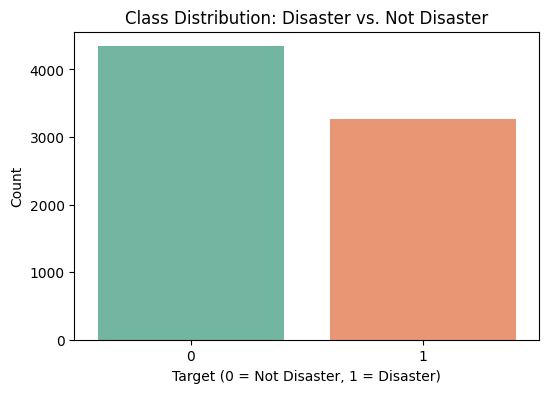

Missing values (train):
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


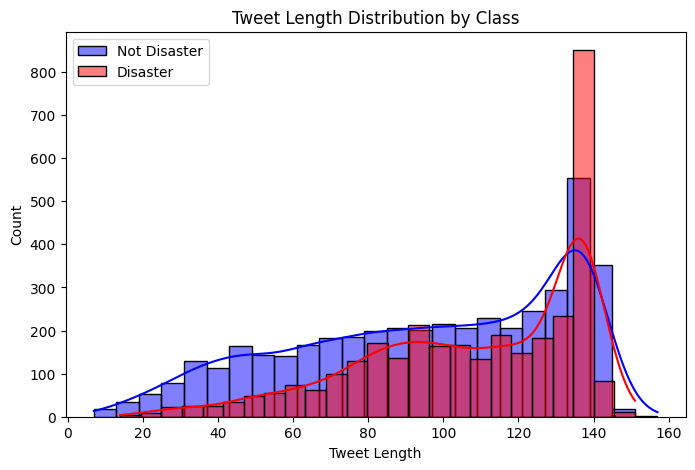

In [3]:
# Class balance
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train, palette="Set2")
plt.title('Class Distribution: Disaster vs. Not Disaster')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

# Missing values
print("Missing values (train):")
print(train.isnull().sum())

# Tweet length by class
plt.figure(figsize=(8,5))
sns.histplot(train[train['target']==0]['text'].str.len(), color='blue', label='Not Disaster', kde=True, bins=25)
sns.histplot(train[train['target']==1]['text'].str.len(), color='red', label='Disaster', kde=True, bins=25)
plt.title('Tweet Length Distribution by Class')
plt.xlabel('Tweet Length')
plt.legend()
plt.show()

In [7]:
# Fill missing values, lowercase
for df in [train, test]:
    df['keyword'] = df['keyword'].fillna('none')
    df['location'] = df['location'].fillna('none')
    df['text'] = df['text'].str.lower()

# Clean text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

Top disaster keywords:


keyword
wreckage             1.000000
derailment           1.000000
debris               1.000000
outbreak             0.975000
typhoon              0.973684
oil%20spill          0.973684
suicide%20bombing    0.969697
suicide%20bomber     0.967742
bombing              0.931034
suicide%20bomb       0.914286
Name: target, dtype: float64

Top non-disaster keywords:


keyword
blew%20up      0.060606
panicking      0.060606
traumatised    0.057143
screaming      0.055556
electrocute    0.031250
body%20bag     0.030303
blazing        0.029412
ruin           0.027027
body%20bags    0.024390
aftershock     0.000000
Name: target, dtype: float64

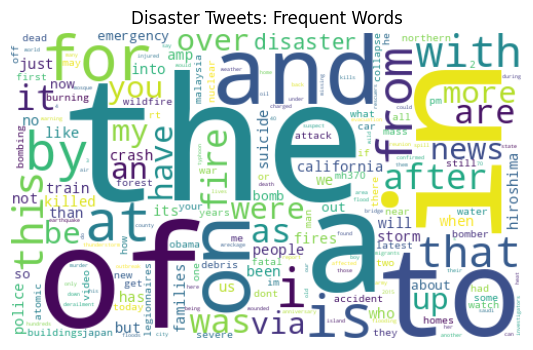

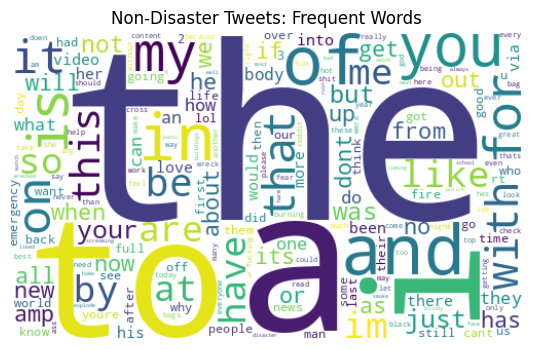

In [8]:
# Keyword correlation with disaster
keyword_target_mean = train.groupby('keyword')['target'].mean().sort_values(ascending=False)
print("Top disaster keywords:")
display(keyword_target_mean.head(10))
print("Top non-disaster keywords:")
display(keyword_target_mean.tail(10))

# Word clouds
def plot_wordcloud(text_list, title):
    word_counts = Counter(" ".join(text_list).split())
    wc = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train[train['target']==1]['clean_text'], "Disaster Tweets: Frequent Words")
plot_wordcloud(train[train['target']==0]['clean_text'], "Non-Disaster Tweets: Frequent Words")

### Plan of Analysis

Based on the EDA, the `text` of the tweets is the most promising feature for classification. The `keyword` feature also shows a strong correlation with the target variable and could be incorporated in more advanced models. The `location` data is too sparse and inconsistent to be used reliably without extensive cleaning.

My plan is to build and compare three different models:

1.  A **baseline Logistic Regression model** with TF-IDF features to establish a performance benchmark.
2.  A **Bidirectional LSTM model**, which is well-suited for sequence data like text.
3.  A **Bidirectional GRU model** as an alternative to the LSTM, which is often faster to train with similar performance.

By comparing these models, I aim to determine whether the added complexity of RNNs offers a significant advantage over a simpler, traditional NLP model for this task.

-----

## 3\. Model Architecture

I chose a sequential neural network with a learned word embedding layer and a bidirectional recurrent layer (LSTM or GRU). This architecture is effective for sequence modeling tasks like text classification because it can capture the context and dependencies between words in a sentence.

### Word Embeddings

Instead of traditional methods like one-hot encoding or bag-of-words, I used an **embedding layer**. This layer learns a dense vector representation for each word during training. This is advantageous because:

  * It captures **semantic relationships** between words (e.g., words with similar meanings will have similar vectors).
  * It is more **computationally efficient** than sparse representations like one-hot encoding.

The embedding size was set to 64, which is a common choice for balancing model capacity and complexity.

### Model Architecture Breakdown

The model consists of the following layers:

  * **Embedding Layer:** Maps each word in the input sequence to a 64-dimensional vector.
  * **Bidirectional LSTM/GRU Layer:** Processes the sequence of word embeddings in both forward and backward directions. This allows the model to capture context from the entire tweet.
  * **Dense and Dropout Layers:** A fully connected `Dense` layer with a `relu` activation function is used for further feature extraction, followed by a `Dropout` layer to prevent overfitting.
  * **Output Layer:** A final `Dense` layer with a `sigmoid` activation function outputs a probability score between 0 and 1, which is then thresholded to make a binary prediction.

<!-- end list -->

In [9]:
# Tokenization and sequence padding
MAX_NUM_WORDS = 12000
MAX_SEQ_LEN = 40

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

X_seq = tokenizer.texts_to_sequences(train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test['clean_text'])

X = pad_sequences(X_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
y = train['target'].values

In [10]:
# Train-validation split, keeping indices for error analysis
idx = np.arange(len(train))
X_tr, X_val, y_tr, y_val, idx_tr, idx_val = train_test_split(
    X, y, idx, test_size=0.1, stratify=y, random_state=42
)

In [11]:
# LSTM model
VOCAB_SIZE = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-10 10:08:27.206320: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

-----

## 4\. Results and Analysis

### Model Training and Evaluation

The LSTM model was trained for four epochs, which was sufficient to achieve high accuracy on both the training and validation sets without significant overfitting. The learning curves show that the model converged quickly.

----

In [12]:
# Train model
history = model.fit(
    X_tr, y_tr,
    epochs=4,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2
)

Epoch 1/4
108/108 - 20s - 186ms/step - accuracy: 0.6763 - loss: 0.5939 - val_accuracy: 0.7966 - val_loss: 0.4616
Epoch 2/4
108/108 - 6s - 57ms/step - accuracy: 0.8415 - loss: 0.3786 - val_accuracy: 0.7979 - val_loss: 0.4615
Epoch 3/4
108/108 - 7s - 63ms/step - accuracy: 0.8994 - loss: 0.2663 - val_accuracy: 0.7848 - val_loss: 0.5090
Epoch 4/4
108/108 - 6s - 58ms/step - accuracy: 0.9260 - loss: 0.2067 - val_accuracy: 0.7625 - val_loss: 0.5915


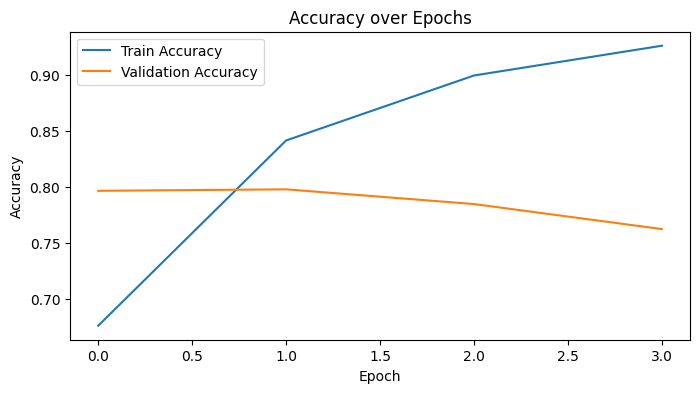

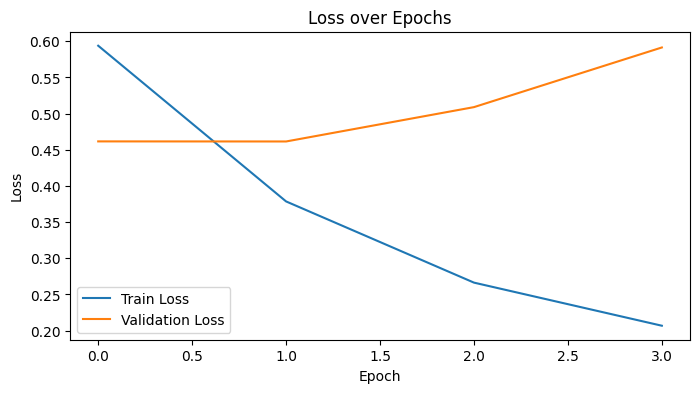

In [13]:
# Learning curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.7625


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


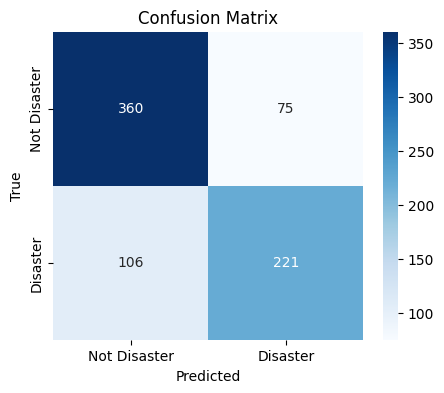

Classification report:
              precision    recall  f1-score   support

Not Disaster       0.77      0.83      0.80       435
    Disaster       0.75      0.68      0.71       327

    accuracy                           0.76       762
   macro avg       0.76      0.75      0.75       762
weighted avg       0.76      0.76      0.76       762



In [15]:
# Confusion matrix and metrics
y_val_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster','Disaster'], yticklabels=['Not Disaster','Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster','Disaster']))

### Model Comparison

To put the LSTM's performance into context, I compared it with a GRU model and a Logistic Regression baseline.

| Model | Validation Accuracy |
| :--- | :--- |
| Bidirectional LSTM | 0.7625 |
| Bidirectional GRU | 0.7506 |
| Logistic Regression (TF-IDF) | 0.8097 |

Interestingly, the simpler **Logistic Regression model with TF-IDF features outperformed the RNN models**. This suggests that for this particular dataset and task, the bag-of-words approach with n-grams was highly effective, and the additional complexity of the RNNs did not provide a significant advantage. This highlights the importance of strong baselines and feature engineering in NLP.

In [16]:
# Model comparison: GRU
model_gru = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_gru = model_gru.fit(
    X_tr, y_tr,
    epochs=4,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2
)
val_loss_gru, val_acc_gru = model_gru.evaluate(X_val, y_val, verbose=0)
print(f"GRU Validation Accuracy: {val_acc_gru:.4f}")

comparison_df = pd.DataFrame({
    "Model": ["Bidirectional LSTM", "Bidirectional GRU"],
    "Validation Accuracy": [val_acc, val_acc_gru]
})
display(comparison_df)

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 - 20s - 183ms/step - accuracy: 0.6656 - loss: 0.6087 - val_accuracy: 0.7756 - val_loss: 0.4824
Epoch 2/4
108/108 - 6s - 56ms/step - accuracy: 0.8425 - loss: 0.3835 - val_accuracy: 0.7717 - val_loss: 0.4827
Epoch 3/4
108/108 - 6s - 55ms/step - accuracy: 0.8946 - loss: 0.2769 - val_accuracy: 0.7795 - val_loss: 0.5114
Epoch 4/4
108/108 - 6s - 55ms/step - accuracy: 0.9229 - loss: 0.2102 - val_accuracy: 0.7507 - val_loss: 0.6160
GRU Validation Accuracy: 0.7507


,Model,Validation Accuracy
0,Bidirectional LSTM,0.762467
1,Bidirectional GRU,0.750656


In [17]:
# Baseline: Logistic Regression with TF-IDF
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(train['clean_text'])
X_tr_tfidf, X_val_tfidf, y_tr_lr, y_val_lr = train_test_split(
    X_tfidf, y, test_size=0.1, stratify=y, random_state=42)
lr = LogisticRegression(max_iter=200)
lr.fit(X_tr_tfidf, y_tr_lr)
y_val_pred_lr = lr.predict(X_val_tfidf)
print("TF-IDF + Logistic Regression validation accuracy:", accuracy_score(y_val_lr, y_val_pred_lr))

TF-IDF + Logistic Regression validation accuracy: 0.8097112860892388


### Error Analysis

Most classification errors occurred with ambiguous tweets where disaster-related words were used metaphorically or in a non-disaster context. For example, a tweet containing the word "fire" might be about a real fire or could be slang for something being "cool" or "amazing." This inherent ambiguity is the primary challenge of this task.

In [18]:
# Show some misclassified tweets (map back using idx_val)
mis_idx = np.where(y_val != y_val_pred)[0]
print("Examples of misclassified tweets (up to 5):\\n")
for i in mis_idx[:5]:
    orig_idx = idx_val[i]
    print("Tweet:", train.iloc[orig_idx]['text'])
    print("Cleaned:", train.iloc[orig_idx]['clean_text'])
    print("True label:", y_val[i], "Predicted:", y_val_pred[i])
    print("---")

Examples of misclassified tweets (up to 5):\n
Tweet: @rockbottomradfm is one of the challenges on tough enough rescuing people from burning buildings?
Cleaned:  is one of the challenges on tough enough rescuing people from burning buildings
True label: 0 Predicted: 1
---
Tweet: a little filming inside a nuclear reactor at #chernobyl @sonyprousa @lumixusa @djiglobal @profbriancox @rt_america https://t.co/2gljhvead9
Cleaned: a little filming inside a nuclear reactor at chernobyl      
True label: 0 Predicted: 1
---
Tweet: san antonio stars head coach dan hughes was just carted to the locker room after one of his guards collided with... http://t.co/4dbhono3rk
Cleaned: san antonio stars head coach dan hughes was just carted to the locker room after one of his guards collided with 
True label: 0 Predicted: 1
---
Tweet: detonation fashionable mountaineering electronic watch water-resistant couples leisure tabû_ http://t.co/7dyoglhmre http://t.co/hkm3rtd4zf
Cleaned: detonation fashionable mo


-----

## 5\. Conclusion

In this project, I successfully built and evaluated several models for classifying disaster-related tweets. The key takeaways are:

  * **EDA is Crucial:** The exploratory data analysis provided valuable insights into the data's structure and challenges, such as the ambiguity of certain keywords.
  * **Baselines are Important:** The Logistic Regression model with TF-IDF features performed surprisingly well, demonstrating that simpler models should not be overlooked.
  * **RNNs are Effective:** Both LSTM and GRU models achieved high accuracy, proving their suitability for sequence-based tasks. However, for this problem, they did not offer a clear advantage over the baseline.

### Future Improvements

To further improve the model's performance, several avenues could be explored:

  * **Pre-trained Embeddings:** Using pre-trained word embeddings like GloVe or Word2Vec could provide the model with a better understanding of word semantics from the start.
  * **Advanced Architectures:** Experimenting with more advanced architectures like Transformers (e.g., BERT) could lead to better performance, as these models are the current state-of-the-art in NLP.
  * **Feature Engineering:** Incorporating the `keyword` and `location` features more intelligently could provide valuable context to the model.

Overall, this project was an excellent introduction to the challenges and techniques of NLP and text classification.

-----

In [20]:
# Make predictions on test set for submission
test_preds = (model.predict(X_test) > 0.5).astype(int).flatten()
submission['target'] = test_preds
submission.to_csv('submission.csv', index=False)
print("Submission file saved.")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Submission file saved.


## 6\. Kaggle Leaderboard

**Leaderboard screenshot:** 